In [1]:
# TODO: running this once ate a single rq and 164 processing units (looking at Riga for a single date)
# I should probably do some of the computation locally to reduce credit usage

In [51]:
# https://github.com/eu-cdse/notebook-samples/blob/main/sentinelhub/deforestation_monitoring_with_xarray.ipynb
import os
import scipy
import numpy as np
import xarray as xr
import rasterio
import requests
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

from settings import client_id, client_secret, config_name, config_file

from pathlib import Path
from datetime import datetime
from ipyleaflet import GeoJSON, Map, basemaps
from sentinelhub import SHConfig, BBox, CRS, SentinelHubRequest, DataCollection, MimeType, SentinelHubDownloadClient
from sklearn.metrics import accuracy_score


In [28]:
config = None

if os.path.isfile(config_file):
    config = SHConfig(open(config_file, "r").read())
else:
    config = SHConfig()
    config.sh_client_id = client_id
    config.sh_client_secret = client_secret
    config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
    config.sh_base_url = "https://sh.dataspace.copernicus.eu"
    config.save(config_name)

    open(config_file, "w").write(config_name)


In [3]:
resolution = (100, 100)
#bbox_coords = [22.9, 56.4, 26.5, 57.0] - causes timeouts
bbox_coords = [23.0, 56.5, 24.5, 57.2]
epsg = 3035

# Convert to 3035 to get crs with meters as units
bbox = BBox(bbox_coords, CRS(4326)).transform(epsg)
x, y = bbox.transform(4326).middle

overview_map = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=(y, x), zoom=10)
geo_json = GeoJSON(data=bbox.transform(4326).geojson)
overview_map.add_layer(geo_json)


In [4]:
evalscript_cloudless = """
//VERSION=3
function setup() {
    return {
        input: ["B08", "B04", "B03", "B02", "SCL"],
        output: {
            bands: 4,
            sampleType: "INT16"
        },
        mosaicking: "ORBIT"
    }
}

function getFirstQuartileValue(values) {
    values.sort((a,b) => a-b);
    return getFirstQuartile(values);
}

function getFirstQuartile(sortedValues) {
    var index = Math.floor(sortedValues.length / 4);
    return sortedValues[index];
}

function validate(sample) {
    // Define codes as invalid:
    const invalid = [
        0, // NO_DATA
        1, // SATURATED_DEFECTIVE
        3, // CLOUD_SHADOW
        7, // CLOUD_LOW_PROBA
        8, // CLOUD_MEDIUM_PROBA
        9, // CLOUD_HIGH_PROBA
        10 // THIN_CIRRUS
    ]
    return !invalid.includes(sample.SCL)
}

function evaluatePixel(samples) {
    var valid = samples.filter(validate);
    if (valid.length > 0 ) {
        let cloudless = {
            b08: getFirstQuartileValue(valid.map(s => s.B08)),
            b04: getFirstQuartileValue(valid.map(s => s.B04)),
            b03: getFirstQuartileValue(valid.map(s => s.B03)),
            b02: getFirstQuartileValue(valid.map(s => s.B02)),
        }
        let ndvi = ((cloudless.b08 - cloudless.b04) / (cloudless.b08 + cloudless.b04))
        // This applies a scale factor so the data can be saved as an int
        let scale = [cloudless.b04, cloudless.b03, cloudless.b02, ndvi].map(v => v*10000);
        return scale
    }
    // If there isn't enough data, return NODATA
    return [-32768, -32768, -32768, -32768]
}
"""


In [5]:
def interval_of_interest(year):
    return (datetime(year, 6, 1), datetime(year, 9, 1))


def get_request(year):
    time_interval = interval_of_interest(year)
    return SentinelHubRequest(
        evalscript=evalscript_cloudless,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A.define_from(
                    "s2", service_url=config.sh_base_url
                ),
                time_interval=time_interval,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=bbox,
        resolution=resolution,
        config=config,
        data_folder="./data",
    )


In [15]:
# create a dictionary of requests
sh_requests = {}
for year in range(2018, 2024):
    sh_requests[year] = get_request(year)

sh_requests


{2018: <sentinelhub.api.process.SentinelHubRequest at 0x10ece9450>,
 2019: <sentinelhub.api.process.SentinelHubRequest at 0x10ece96d0>,
 2020: <sentinelhub.api.process.SentinelHubRequest at 0x10ed4e190>,
 2021: <sentinelhub.api.process.SentinelHubRequest at 0x10ed4e3f0>,
 2022: <sentinelhub.api.process.SentinelHubRequest at 0x10edb2330>,
 2023: <sentinelhub.api.process.SentinelHubRequest at 0x10ee25d00>}

In [16]:
list_of_requests = [request.download_list[0] for request in sh_requests.values()]

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(
    list_of_requests, max_threads=5
)


In [17]:
def request_output_path(request):
    # Gets the full path to the output from a request
    print(request.data_folder)
    print(request.get_filename_list()[0])
    return Path(request.data_folder, request.get_filename_list()[0])


# Moves and renames the files to the root directory of results
for year, request in sh_requests.items():
    print(year)
    print(request)
    request_output_path(request).rename(f"./data/{year}.tif")
    

2018
./data
e13874c1171ee50aa73c0cad07883600/response.tiff
2019
./data
e4c9ff27aeb9d0e3bd2871afd14eb4f9/response.tiff
2020
./data
92776c7b564cd427be7a8ae854c24d12/response.tiff
2021
./data
72bb57a40998c9454665776322dced98/response.tiff
2022
./data
2537bc0270a4f4ea09386ae08b18931a/response.tiff
2023
./data
572175d15d4dc9f1b38ded1da67f8656/response.tiff


In [18]:
def add_time_dim(xda):
    # This pre-processes the file to add the correct
    # year from the filename as the time dimension
    year = int(Path(xda.encoding["source"]).stem)
    return xda.expand_dims(year=[year])


In [19]:
tiff_paths = Path("./data").glob("*.tif")
ds_s2 = xr.open_mfdataset(
    tiff_paths,
    engine="rasterio",
    preprocess=add_time_dim,
    band_as_variable=True,
)
ds_s2 = ds_s2.rename(
    {
        "band_1": "R",
        "band_2": "G",
        "band_3": "B",
        "band_4": "NDVI",
    }
)
ds_s2 = ds_s2 / 10000


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0048..2.332].


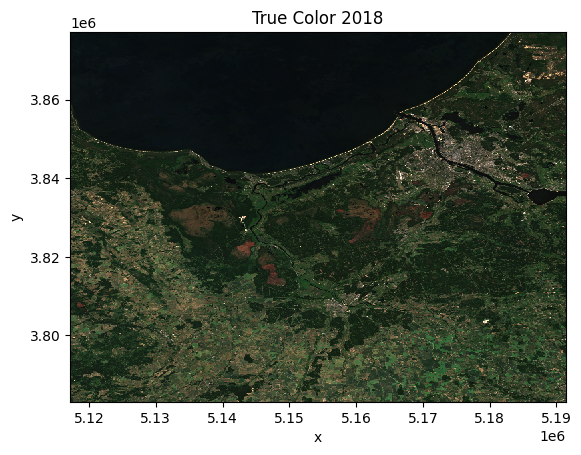

In [20]:
# Get RGB data for a year
plot_year = 2018
true_color = ds_s2.sel(year=plot_year)[["R", "G", "B"]].to_array()
# Divide by scale factor and apply gamma to brighten image
(true_color * 4).plot.imshow()
plt.title(f"True Color {plot_year}");


In [21]:
ds_s2

<xarray.Dataset> Size: 67MB
Dimensions:      (year: 6, x: 743, y: 941)
Coordinates:
  * year         (year) int64 48B 2018 2019 2020 2021 2022 2023
  * x            (x) float64 6kB 5.117e+06 5.117e+06 ... 5.191e+06 5.191e+06
  * y            (y) float64 8kB 3.877e+06 3.877e+06 ... 3.783e+06 3.783e+06
    spatial_ref  int64 8B 0
Data variables:
    R            (year, y, x) float32 17MB dask.array<chunksize=(1, 8, 743), meta=np.ndarray>
    G            (year, y, x) float32 17MB dask.array<chunksize=(1, 8, 743), meta=np.ndarray>
    B            (year, y, x) float32 17MB dask.array<chunksize=(1, 8, 743), meta=np.ndarray>
    NDVI         (year, y, x) float32 17MB dask.array<chunksize=(1, 8, 743), meta=np.ndarray>
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area

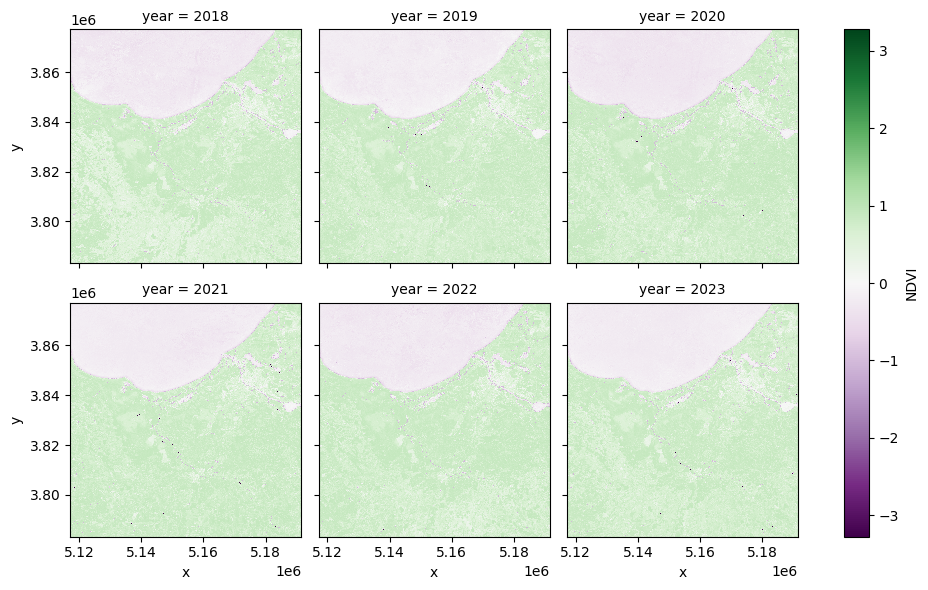

In [22]:
ds_s2.NDVI.plot(cmap="PRGn", x="x", y="y", col="year", col_wrap=3)


In [23]:
ds_s2["FOREST"] = ds_s2.NDVI > 0.7


(0.0, 3817.712)

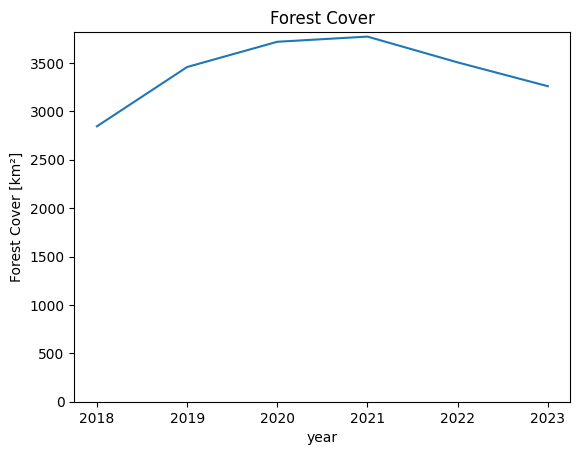

In [29]:
def to_km2(dataarray, resolution):
    # Calculate forest area
    return dataarray * np.prod(list(resolution)) / 1e6


forest_pixels = ds_s2.FOREST.sum(["x", "y"])
forest_area_km2 = to_km2(forest_pixels, resolution)
forest_area_km2.plot()
plt.title("Forest Cover")
plt.ylabel("Forest Cover [km²]")
plt.ylim(0)


Text(0.5, 1.0, 'Forest Change Map 2022')

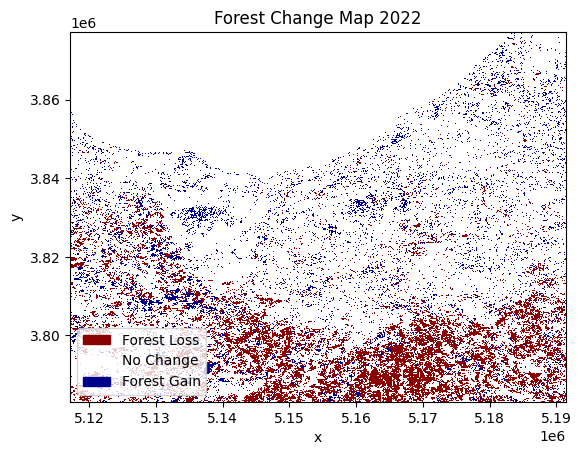

In [34]:
# Make change maps of forest loss and forest gain compared to previous year

# 0 - 0 = No Change: 0
# 1 - 1 = No Change: 0
# 1 - 0 = Forest Gain: 1
# 0 - 1 = Forest Loss: -1

# Define custom colors and labels
colors = ["darkred", "white", "darkblue"]
labels = ["Forest Loss", "No Change", "Forest Gain"]

# Create a colormap and normalize it
cmap = mcolors.ListedColormap(colors)
norm = plt.Normalize(-1, 1)  # Adjust the range based on your data

plot_year = 2022
ds_s2["CHANGE"] = ds_s2.FOREST.astype(int).diff("year", label="upper")
ds_s2.CHANGE.sel(year=plot_year).plot(cmap=cmap, norm=norm, add_colorbar=False)

# Create a legend with string labels
legend_patches = [
    mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)
]
plt.legend(handles=legend_patches, loc="lower left")
plt.title(f"Forest Change Map {plot_year}")


Text(0, 0.5, 'Forest Loss [km²]')

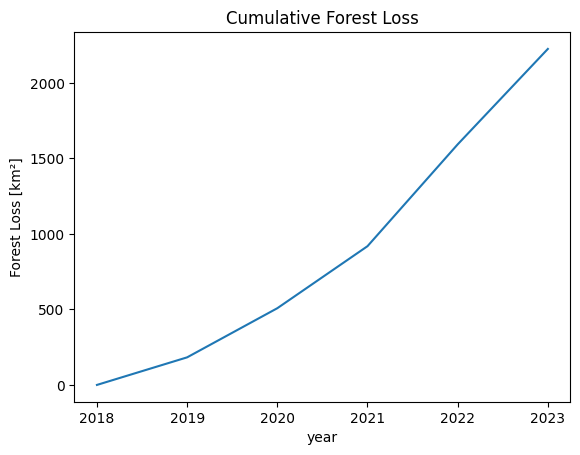

In [35]:
# Forest Loss per Year
forest_loss = (ds_s2.CHANGE == -1).sum(["x", "y"])
forest_loss_km2 = to_km2(forest_loss, resolution)
forest_loss_km2.cumsum().plot()
plt.title("Cumulative Forest Loss")
plt.ylabel("Forest Loss [km²]")


In [40]:
# https://storage.googleapis.com/earthenginepartners-hansen/GFC-2022-v1.10/download.html

In [41]:
data_path = Path("./data/")
data_path.mkdir(parents=True, exist_ok=True)
hansen_filename = "Hansen_GFC-2022-v1.10_lossyear_60N_020E.tif"
comp_data = data_path / hansen_filename

with comp_data.open("wb") as fs:
    hansen_data = requests.get(
        f"https://storage.googleapis.com/earthenginepartners-hansen/GFC-2022-v1.10/{hansen_filename}"
    )
    fs.write(hansen_data.content)
    

Text(0.5, 1.0, 'Global Forest Watch Data')

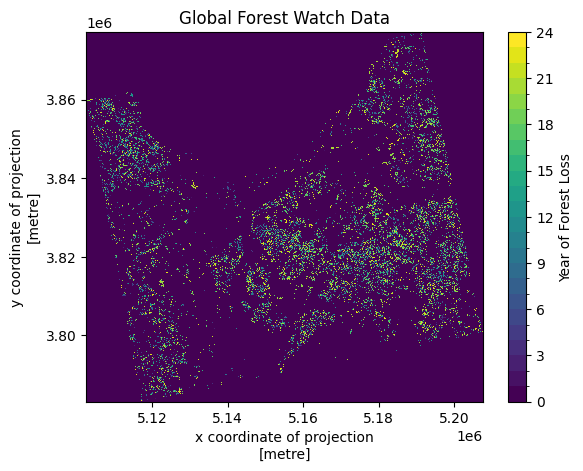

In [42]:
# Open the file
ground_truth = (
    xr.open_dataarray(comp_data, engine="rasterio")
    .rio.clip_box(*bbox_coords)
    .rio.reproject(epsg)
    .sel(band=1)
    .where(lambda gt: gt < 100, 0)  # fill no-data (values over 100) with 0
)
ground_truth.plot(levels=range(25), cbar_kwargs={"label": "Year of Forest Loss"})
plt.title("Global Forest Watch Data")


In [46]:
ds_s2["GROUND_TRUTH"] = ground_truth.interp_like(ds_s2, method="nearest").astype(int)
ds_s2


<xarray.Dataset> Size: 110MB
Dimensions:       (year: 6, x: 743, y: 941)
Coordinates:
  * year          (year) int64 48B 2018 2019 2020 2021 2022 2023
  * x             (x) float64 6kB 5.117e+06 5.117e+06 ... 5.191e+06 5.191e+06
  * y             (y) float64 8kB 3.877e+06 3.877e+06 ... 3.783e+06 3.783e+06
    spatial_ref   int64 8B 0
    band          int64 8B 1
Data variables:
    R             (year, y, x) float32 17MB dask.array<chunksize=(1, 8, 743), meta=np.ndarray>
    G             (year, y, x) float32 17MB dask.array<chunksize=(1, 8, 743), meta=np.ndarray>
    B             (year, y, x) float32 17MB dask.array<chunksize=(1, 8, 743), meta=np.ndarray>
    NDVI          (year, y, x) float32 17MB dask.array<chunksize=(1, 8, 743), meta=np.ndarray>
    FOREST        (year, y, x) bool 4MB dask.array<chunksize=(1, 8, 743), meta=np.ndarray>
    CHANGE        (year, y, x) float64 34MB dask.array<chunksize=(1, 8, 743), meta=np.ndarray>
    GROUND_TRUTH  (y, x) int64 6MB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area

Text(0.5, 1.0, 'Classification Forest Loss Year')

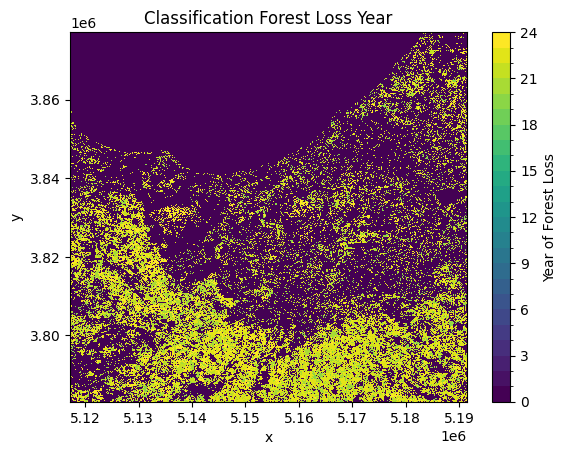

In [47]:
# convert lost forest (-1) into the year it was lost
lost_year = (ds_s2.CHANGE == -1) * ds_s2.year % 100
first_nonzero = (lost_year != 0).argmax(axis=0).compute()
ds_s2["LOST_YEAR"] = lost_year[first_nonzero]
ds_s2.LOST_YEAR.plot(levels=range(25), cbar_kwargs={"label": "Year of Forest Loss"})
plt.title("Classification Forest Loss Year")


Text(0.5, 1.0, 'Global Forest Watch - Interpolated')

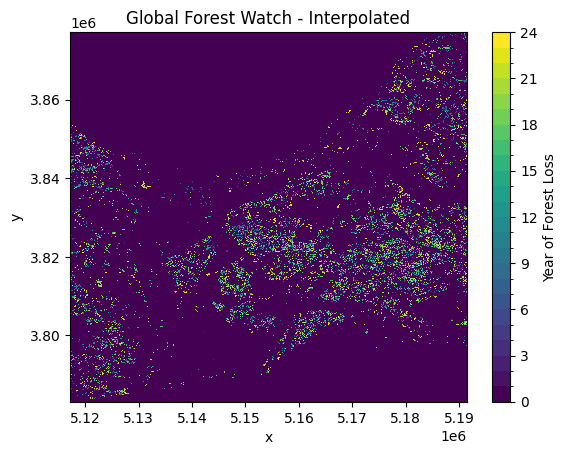

In [48]:
ds_s2.GROUND_TRUTH.plot(levels=range(25), cbar_kwargs={"label": "Year of Forest Loss"})
plt.title("Global Forest Watch - Interpolated")


In [52]:
score = accuracy_score(
    (ds_s2.LOST_YEAR > 18).values.ravel(), (ds_s2.GROUND_TRUTH > 18).values.ravel()
)
print(f"The overall accuracy of forest loss detection is {score:.2f}.")


The overall accuracy of forest loss detection is 0.74.
